# Notebook on how to check your spiking data

Author: Eduarda Centeno

The goal is to run a first check on spiking data quality.
Let's start with the necessary packages for the following computations:

In [170]:
## Libraries
import elephant as elep # 0.10.0
import numpy as np # 1.19.2
import neo as neo # 0.9.0
import matplotlib.pyplot as plt # 3.3.4
import seaborn as sns # 0.11.1
import pandas as pd # 0.23.0
import glob
import quantities as pq # 0.12.4
from viziphant.statistics import plot_instantaneous_rates_colormesh, plot_time_histogram, plot_isi_histogram # 0.1.0
from pathlib import Path
from random import sample, seed

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [2]:
%watermark --author "Eduarda Centeno" --date --time --python --machine --iversion --watermark --packages jupyterlab,notebook,matplotlib,viziphant 

pandas     0.23.0
quantities 0.12.4
seaborn    0.11.1
elephant   0.10.0
neo        0.9.0
numpy      1.19.2
Eduarda Centeno 2021-04-28 12:22:18 

CPython 3.6.13
IPython 7.16.1

jupyterlab 3.0.11
notebook 6.3.0
matplotlib 3.3.4
viziphant 0.1.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores  : 8
interpreter: 64bit
watermark 2.0.2


## Defining key parameters, path to data, and importing data with Neo.

In [69]:
# Define relevant variables
spk_ch = 'ch11#1'
songfile = 'labels.txt'

# Recording sampling information
samp_freq = 32000 # sampling frequency
samp_period = 1/samp_freq # sampling period

# Recording time
rec_start = 0 # in seconds
rec_end = 2973.392 # in seconds

# Baseline period
base_beg = 200 # start of baseline period, in seconds (visually obtained in Spike2)
base_end = 1000 # end of baseline period, in seconds (visually obtained in Spike2)

# Singing period
singing_beg = 0 # start of a sining period (visually obtained in Spike2)
singing_end = 112 # end of a singing period (visually obtained in Spike2)

# Save files (for a first run)
save = False

In [4]:
# Define the path to data
path = Path('C:/Users/eduar/Documents/Python/analysis/Spike_DataCheck/')

# Original .smr
SMRfile = path / '2015_03_12_10_04_26_pythonfixed.smr'

# Spike file name
spikefile = path / (spk_ch + '.txt')

# Song labels
songfile = path / songfile

# Spikewave file
spikewvfile = path / ('SpkWF_' + spk_ch + '.txt')

In [5]:
# Importing data with Neo
reader = neo.io.Spike2IO(filename=SMRfile.as_posix()) # reads SMR
data = reader.read_segment(lazy=True) # use lazy=True to consume less time and memory
ch_index = [index for index in range(len(data.spiketrains)) if data.spiketrains[index].annotations['id']==spk_ch][0] # looks for the index of the spiketrain

################################################################################################################
#### How to save individual files, if wanted.
Considering that in this jupyter we will work mainly with the individually saved files, running the cell below is necessary when using this jupyter for the first time.

In [6]:
if save==True:
    # How to save spike trains into a txt file that can be further read and used
    spktrain = data.spiketrains[ch_index].load().as_array()
    np.savetxt(spk_ch+".txt", spktrain)
    # How to save spike waveforms into a txt file that can be further read and used
    waveforms = data.spiketrains[ch_index].load(load_waveforms=True).waveforms # finally loads the waveforms
    with open('SpkWF_' + spk_ch + '.txt', 'w') as outfile:
        for slice_2d in waveforms.magnitude:
            np.savetxt(outfile, slice_2d)

################################################################################################################

In [7]:
# Obtain ndarrays
spike_arr = np.genfromtxt(spikefile) # load all spikes

# Obtain spikes per states
spike_baseline_indexes = np.where(np.logical_and(spike_arr>=base_beg, spike_arr<=base_end)==True)
spikes_baseline = spike_arr[spike_baseline_indexes] # obtain spikes during baseline
spike_singing_indexes = np.where(np.logical_and(spike_arr>=singing_beg, spike_arr<=singing_end)==True)
spikes_singing = spike_arr[spike_singing_indexes] # obtain spikes during a singing period

# Create SpikeTrain neo objects (necessary for some functions)
st = neo.SpikeTrain(times=spike_arr, units='sec', t_start=rec_start, t_stop=rec_end) # SpikeTrain object
st_baseline = neo.SpikeTrain(times=spikes_baseline, units='sec', t_start=base_beg, t_stop=base_end) # SpikeTrain object
st_singing = neo.SpikeTrain(times=spikes_singing, units='sec', t_start=singing_beg, t_stop=singing_end) # SpikeTrain object

## Computing spiking statistics

First, we will compute the mean firing rate. This is just to get some general intuition about the data. The expectatation here would be that the mean firing rate would be higher during singing periods compared to baseline.

*According to Elephant's documentation: The mean firing rate is calculated as the number of spikes in the spike train in the range [t_start, t_stop] divided by the time interval t_stop - t_start*

In [8]:
# Mean firing rate overall
mean_overall = elep.statistics.mean_firing_rate(spike_arr)
print('The mean firing rate for the whole recording: {:.3f}'.format(mean_overall))

The mean firing rate for the whole recording: 0.458


However, it might be more relevant to separate and compare between a resting period and a singing period.

In [9]:
# Mean firing rate during baseline
mean_baseline = elep.statistics.mean_firing_rate(spike_arr, t_start=base_beg, t_stop=base_end)
print('The mean firing rate for the baseline period: {:.3f}'.format(mean_baseline))

The mean firing rate for the baseline period: 0.229


In [10]:
# Mean firing rate during a singing period
mean_singing = elep.statistics.mean_firing_rate(spike_arr, t_start=singing_beg, t_stop=singing_end)
print('The mean firing rate for the singing period: {:.3f}'.format(mean_singing))

The mean firing rate for the singing period: 3.438


## Visualizing spikeshapes, computing the spike width average, and obtaining the signal-to-noise ratio

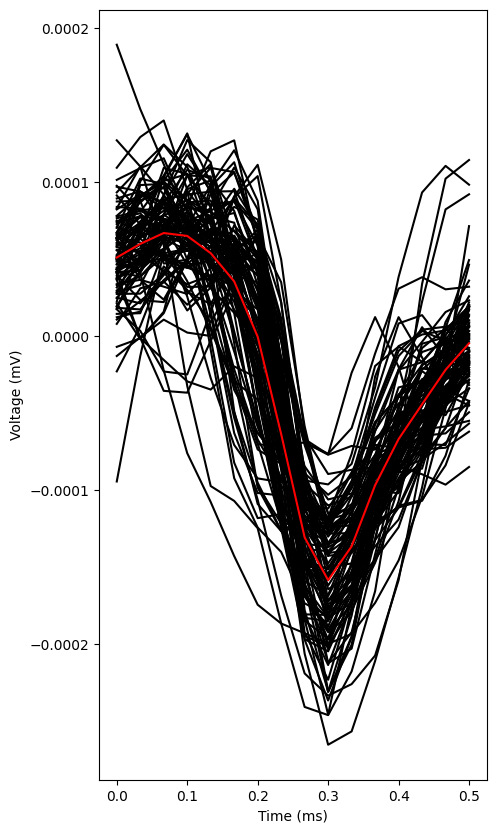

In [174]:
# Overlaid spikeshapes
spk_wvs = np.loadtxt(spikewvfile) # load spike waveforms
#seed(1) # one can use this to keep the random results
random_choice = sample(range(len(spk_wvs)), 100)
spk_wvs_random = spk_wvs[random_choice]

fig, ax = plt.subplots(figsize=(5,10))
ax.set_ylabel('Voltage (mV)')
ax.set_xlabel('Time (ms)')
single_wv = spk_wvs[0]
duration = len(single_wv)/samp_freq # in seconds
duration_ms = duration*1000 # in miliseconds
mean_spike_wv = np.mean(spk_wvs_random, axis=0) # get the average/mean spike shape
for shape in spk_wvs_random:
    ax.plot(np.linspace(0,duration_ms, len(single_wv)), shape, color='black')
ax.plot(np.linspace(0,duration_ms, len(single_wv)), mean_spike_wv, color='red') # Plot mean

In [158]:
# Average spike width. The spike width is defined as the width (trough-to-peak TTP) of a waveform.
average_width_1 = np.mean([elep.waveform_features.waveform_width(shape) for shape in spk_wvs]) # averaging widths
print('The average width across shapes is: {:.3f}'.format(average_width_1/samp_freq*1000) + ' ms')

average_width_2 = elep.waveform_features.waveform_width(mean_spike_wv)
print('The width of the average spike shape is: {:.3f}'.format(average_width_2/samp_freq*1000) + ' ms')

The average width across shapes is: 0.180 ms
The width of the average spike shape is: 0.188 ms


In [13]:
# Signal-to-noise ratio, defined as the difference in mean peak-to-trough voltage divided by twice the mean SD.
SNR = elep.waveform_features.waveform_snr(spk_wvs)
print('SNR = {:.3f}'.format(SNR))

SNR = 3.136


In [14]:
# Signal-to-noise ratio for baseline, defined as the difference in mean peak-to-trough voltage divided by twice the mean SD.
SNR_baseline = elep.waveform_features.waveform_snr(spk_wvs[spike_baseline_indexes])
print('SNR_baseline = {:.3f}'.format(SNR_baseline))

SNR_baseline = 4.408


In [15]:
# Signal-to-noise ratio for singing period, defined as the difference in mean peak-to-trough voltage divided by twice the mean SD.
SNR_singing = elep.waveform_features.waveform_snr(spk_wvs[spike_singing_indexes])
print('SNR_singing = {:.3f}'.format(SNR_singing))

SNR_singing = 3.930


## Plotting the spike train in a few ways

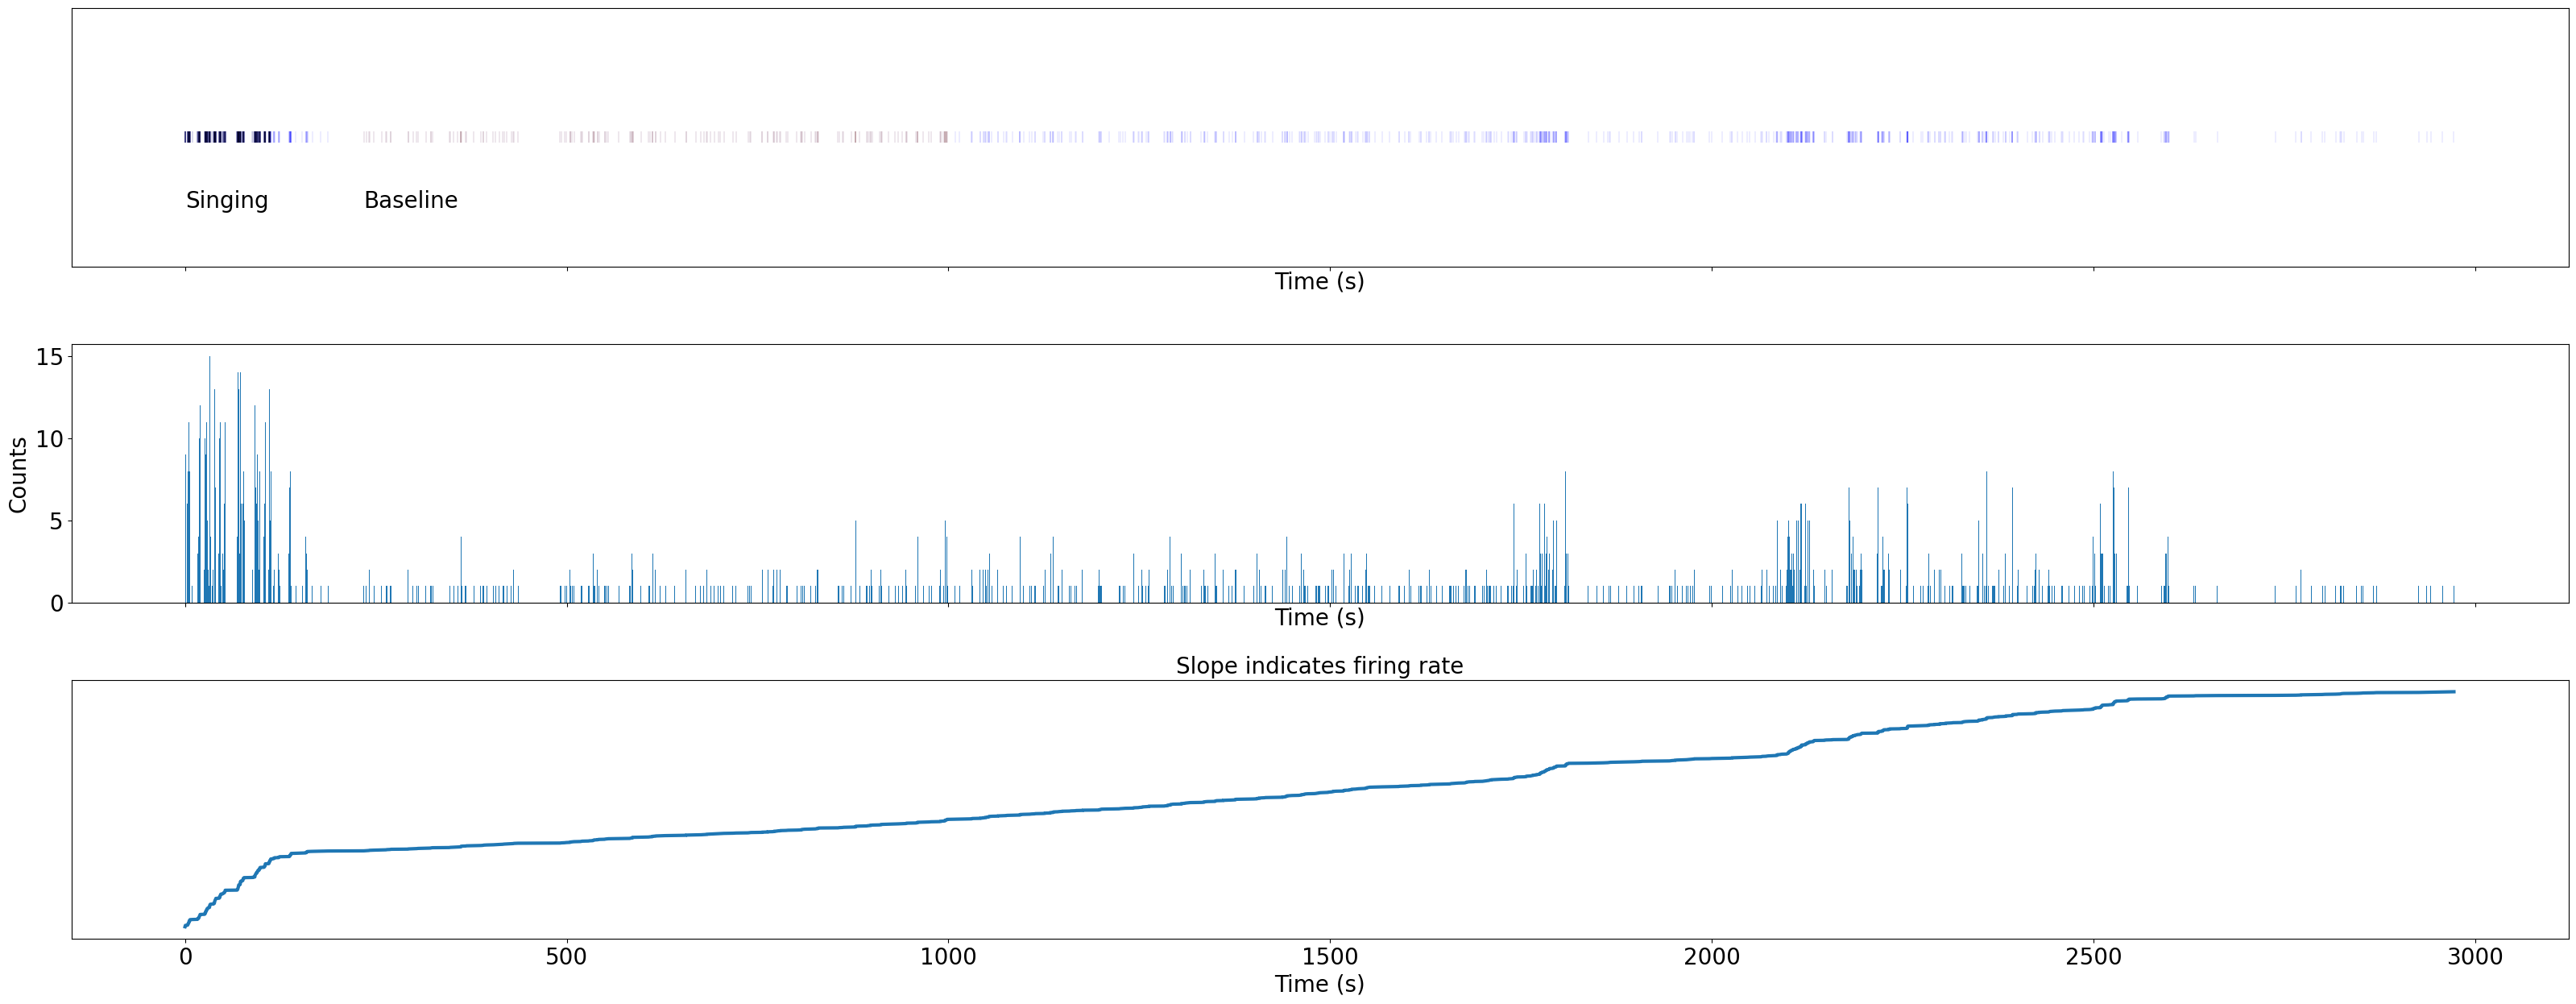

In [156]:
# A simple scatter plot
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(40,15), gridspec_kw=dict(hspace=0.3))
ax[0].scatter(spike_arr, np.ones(len(spike_arr)), marker='|', s=100, c='blue', linewidths=0.1)
ax[0].scatter(spikes_baseline, np.ones(len(spikes_baseline)), marker='|', s=100, linewidths=0.1, c='orange')
ax[0].scatter(spikes_singing, np.ones(len(spikes_singing)), marker='|', s=100, linewidths=0.1, c='black')
ax[0].set_xlabel("Time (s)", fontsize=20)
ax[0].annotate(text='Singing', xy=(spikes_singing[0],0.97), fontsize=20)
ax[0].annotate(text='Baseline', xy=(spikes_baseline[0], 0.97), fontsize=20)
ax[0].set_yticks([])

# Time histogram
histogram = elep.statistics.time_histogram(st, bin_size=1*pq.s)
plot_time_histogram(histogram, units='s', axes=ax[1])
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=20)
ax[1].tick_params(labelsize=20)

# Spiking stability plot (good to plot an spiking stability plot to identify if the unit was not abruptly lost)
ax[2].plot(spike_arr, range(len(spike_arr)), linewidth=3) # plot x using y as index array 0..N-1
ax[2].set_xlabel('Time (s)', fontsize=20)
ax[2].set_yticks([])
ax[2].set_title('Slope indicates firing rate', fontsize=20)
ax[2].tick_params(labelsize=20)

## Now, inter-spike interval histograms, which can help in the identification of neurons.

Let's first compare Elephant's ISI distribution with our home-made ISI plot.

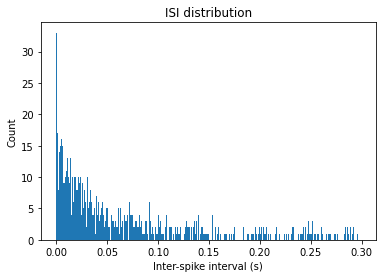

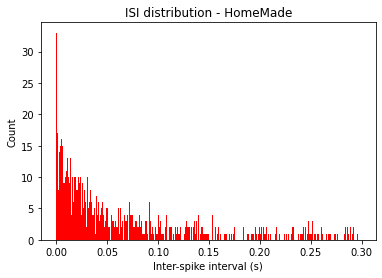

In [19]:
# Interspike interval histogram (whole spiking period)
cutoff = 300 # miiliseconds
bin_size = 1 # miliseconds

# Elephant's version
plot_isi_histogram(st, bin_size=bin_size*pq.ms, cutoff=cutoff*pq.ms, histtype='bar')

# Home-made version
def ISI(spikefile, cutoff, bin_size):
    spikes = np.loadtxt(spikefile)
    times = np.sort(np.diff(spikes))*1000 # multiply per 1000 to convert to miliseconds
    bins = np.arange(0, cutoff, bin_size) # create bins according to cutoff and bin_size
    plt.figure()
    plt.hist(times/1000, bins=bins/1000, color='r') # divide per 1000 to convert back to seconds
    plt.xlabel("Inter-spike interval (s)")
    plt.ylabel("Count")
    plt.title("ISI distribution - HomeMade")
    
ISI(spikefile, cutoff, bin_size)

However, considering that we have different behaviour states in the recording, again, it's important to separate the computations between rest and singing periods.

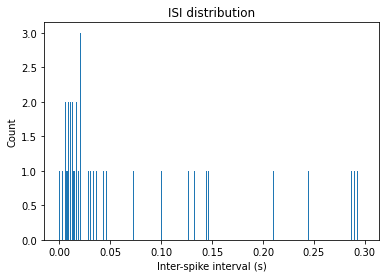

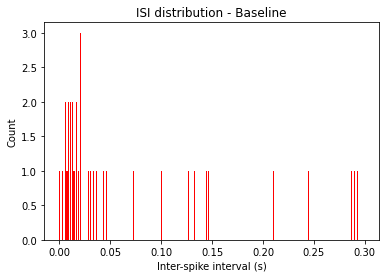

In [20]:
# Visualize ISI only for baseline period

# Elephant's version
plot_isi_histogram(st_baseline, bin_size=bin_size*pq.ms, cutoff=cutoff*pq.ms, histtype='bar')

# Home-made version
def ISI_baseline(spikefile, basebeg, basend, cutoff, bin_size):
    spikes = np.loadtxt(spikefile) # load file
    spikes_baseline = spikes[np.where(np.logical_and(spikes>=basebeg, spikes<=basend)==True)] # find spikes within baseline period
    times = np.sort(np.diff(spikes_baseline))*1000 # get the intervals between spikes and convert into miliseconds
    
    # Create plot
    bins = np.arange(0, cutoff, bin_size)
    plt.figure()
    plt.hist(times/1000, bins=bins/1000, color='r') # divide per 1000 to convert back to seconds
    plt.xlabel('Inter-spike interval (s)')
    plt.ylabel('Count')
    plt.title('ISI distribution - Baseline')
    #plt.xscale('log')
    
ISI_baseline(spikefile, base_beg, base_end, cutoff, bin_size)

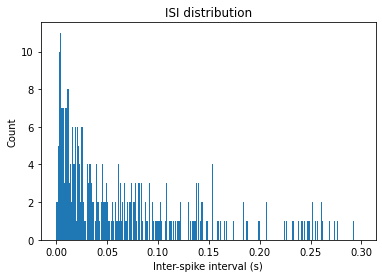

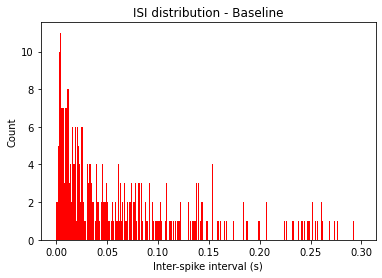

In [21]:
# Visualize ISI only for a singing period

# Elephant's version
plot_isi_histogram(st_singing, bin_size=bin_size*pq.ms, cutoff=cutoff*pq.ms, histtype='bar')

def ISI_singing(spikefile, singingbeg, singingend, cutoff, bin_size):
    spikes = np.loadtxt(spikefile) # load file
    spikes_singing = spikes[np.where(np.logical_and(spikes>=singingbeg, spikes<=singingend)==True)] # find spikes within baseline period
    times = np.sort(np.diff(spikes_singing))*1000 # get the intervals between spikes and convert into miliseconds

    # Create plot
    plt.figure()
    bins = np.arange(0, cutoff, bin_size)
    plt.hist(times/1000, bins=bins/1000, color='r') # divide per 1000 to convert back to seconds
    plt.xlabel('Inter-spike interval (s)')
    plt.ylabel('Count')
    plt.title('ISI distribution - Baseline')
    #plt.xscale('log')
    
ISI_singing(spikefile, singing_beg, singing_end, cutoff, bin_size)

In [22]:
# Coeffifient of variation for whole recording (CV2 and Lv and LvR also available)
cv_overall = elep.statistics.cv(st)
print('The coefficient of variation for the whole recording: {:.3f}'.format(cv_overall))

# Coefficient of variation for baseline period
cv_baseline = elep.statistics.cv(st_baseline)
print('The coefficient of variation for the baseline period: {:.3f}'.format(cv_baseline))

# Coefficient of variation for baseline period
cv_singing = elep.statistics.cv(st_singing)
print('The coefficient of variation for the singing period: {:.3f}'.format(cv_singing))

The coefficient of variation for the whole recording: 0.806
The coefficient of variation for the baseline period: 0.352
The coefficient of variation for the singing period: 0.602


## Now, let's finish with some PSTHs!

In [23]:
%run functions_updated.py

In [24]:
reset_vars()
read_syllable_list('syllable_list.txt')
initialize_song_PSTH('parameters_plot_PSTH_song.txt')

First, let's visualize the standard PSTH. This will allow us to check if the duration of the syllable to be noised matches the noisy syllable (D and X, respectively). That's important because the time warping for the next PSTH expects the same duration. As we can see below, they show the same duration (x axis).
This PSTH removes the gaps between syllables, therefore we need to plot the next PSTH which keeps these gaps.

207
207
85
57
27


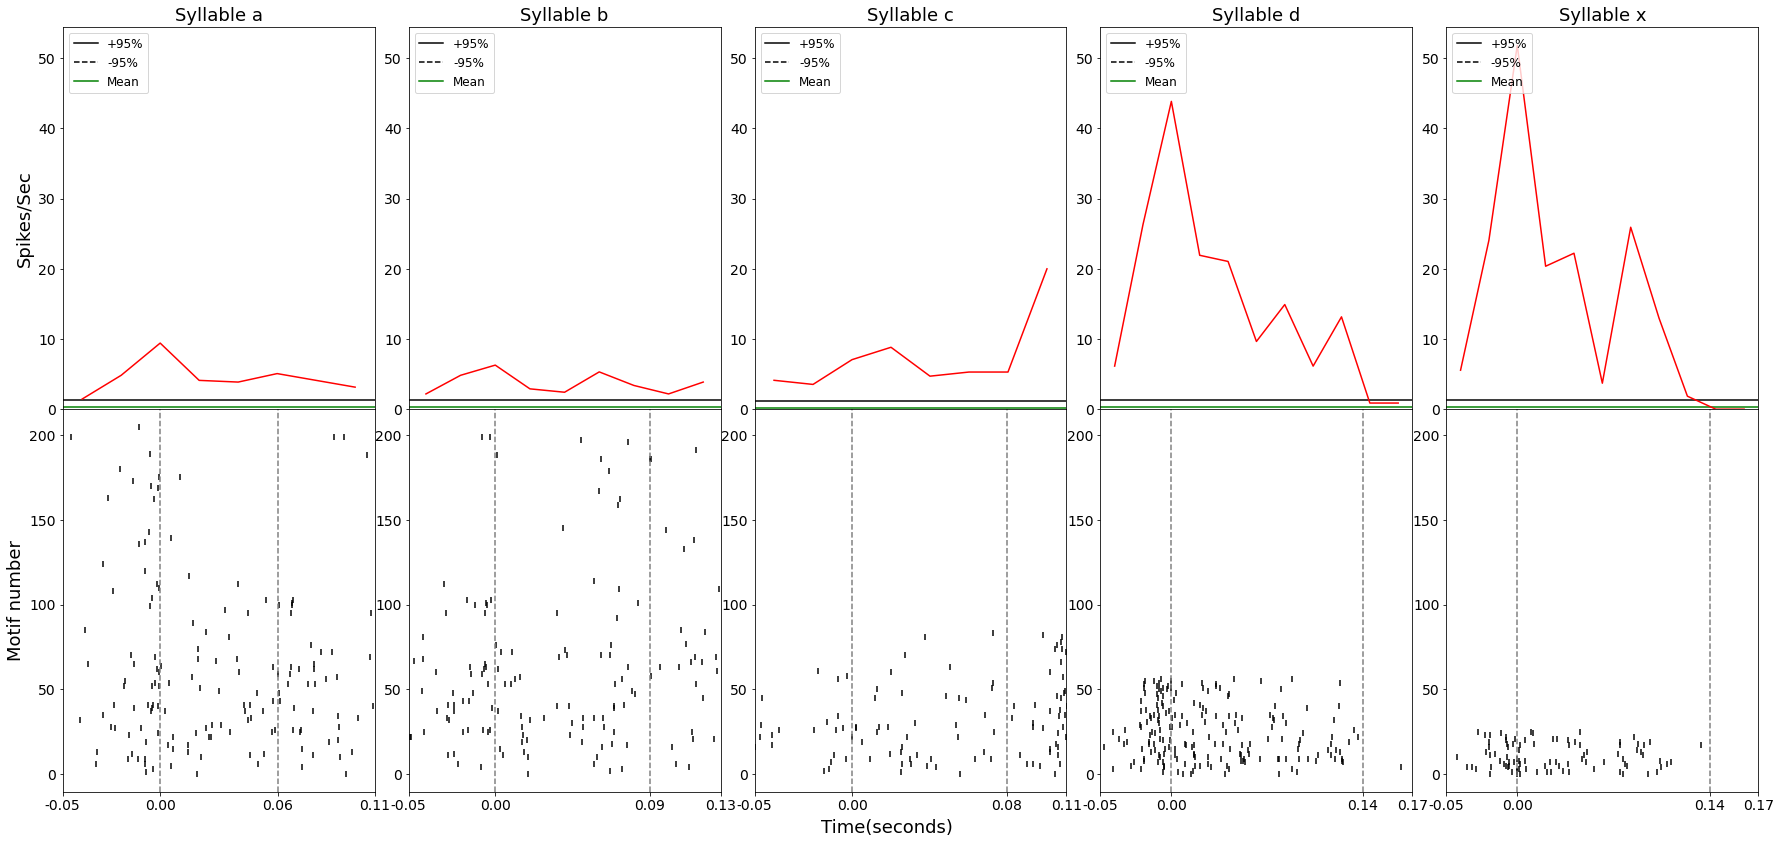

In [25]:
psth(spk_ch + '.txt', 'labels.txt', basebeg=base_beg, basend=base_end)

Now let's see the PSTH comparing the noised syllable with the original one (blue line indicates the noisy syllable).

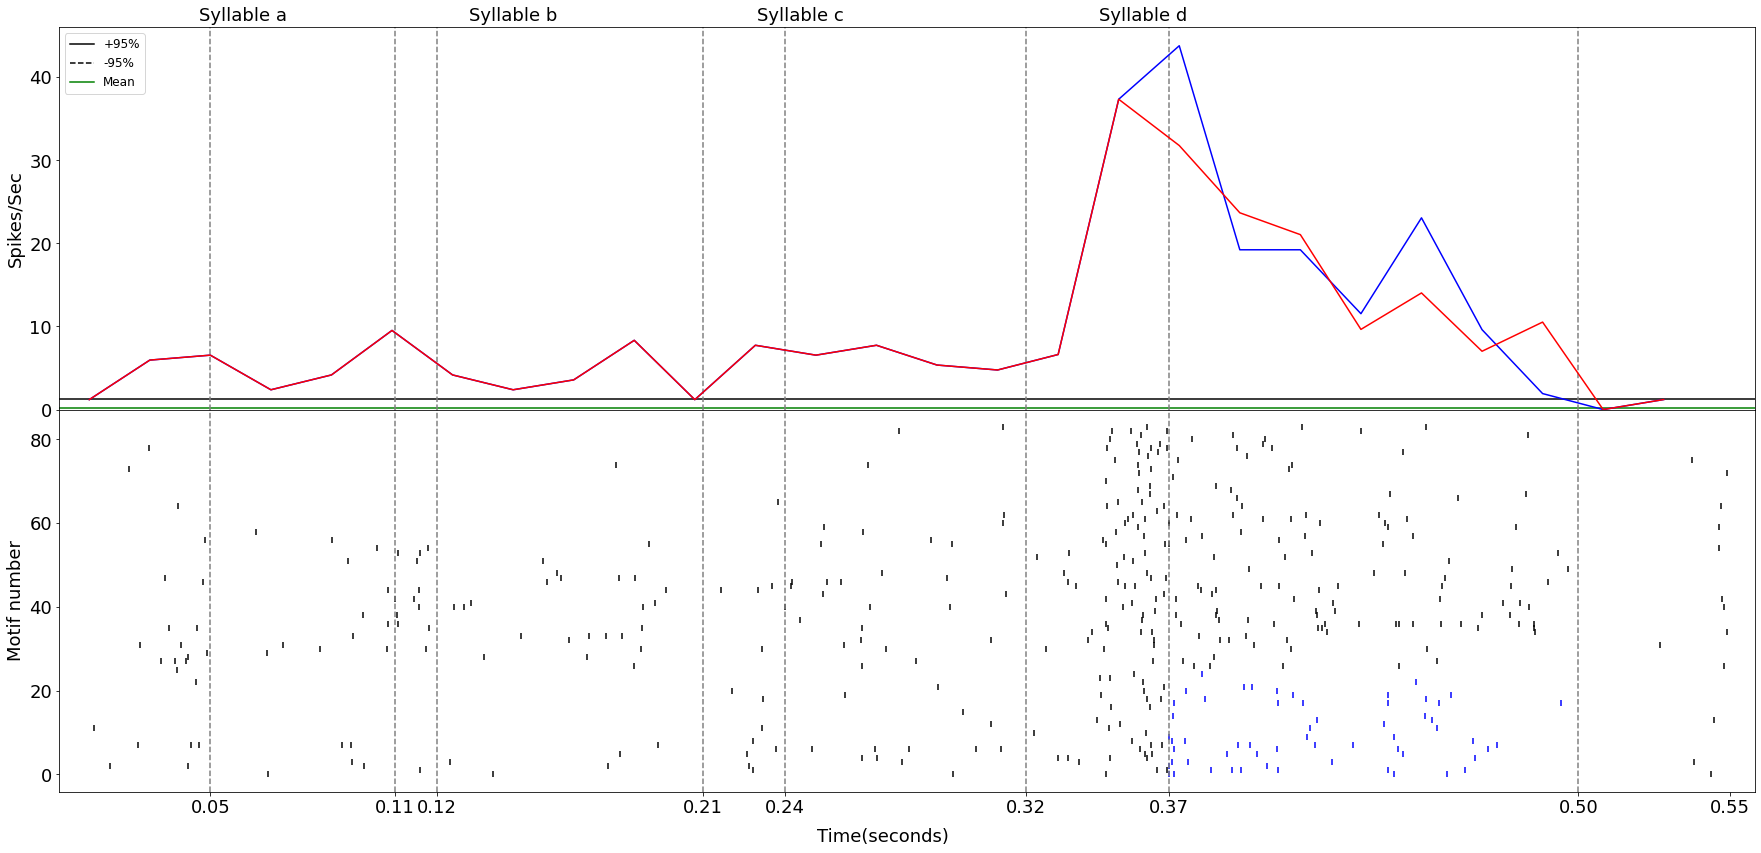

In [26]:
psth_glob(spk_ch + '.txt', 'labels.txt', basebeg=base_beg, basend=base_end)

From the plot above, one could belive that the noised syllable PSTH differs from the normal syllable. To have a more accurate comparison, one should check if this differences were limited to the noisy syllable, or were generally present in the noisy motifs.
As we can see below, the motifs which were target to be noised already showed overall differences with the non-noised motifs. Thus, it was not specific to the noising protocol.

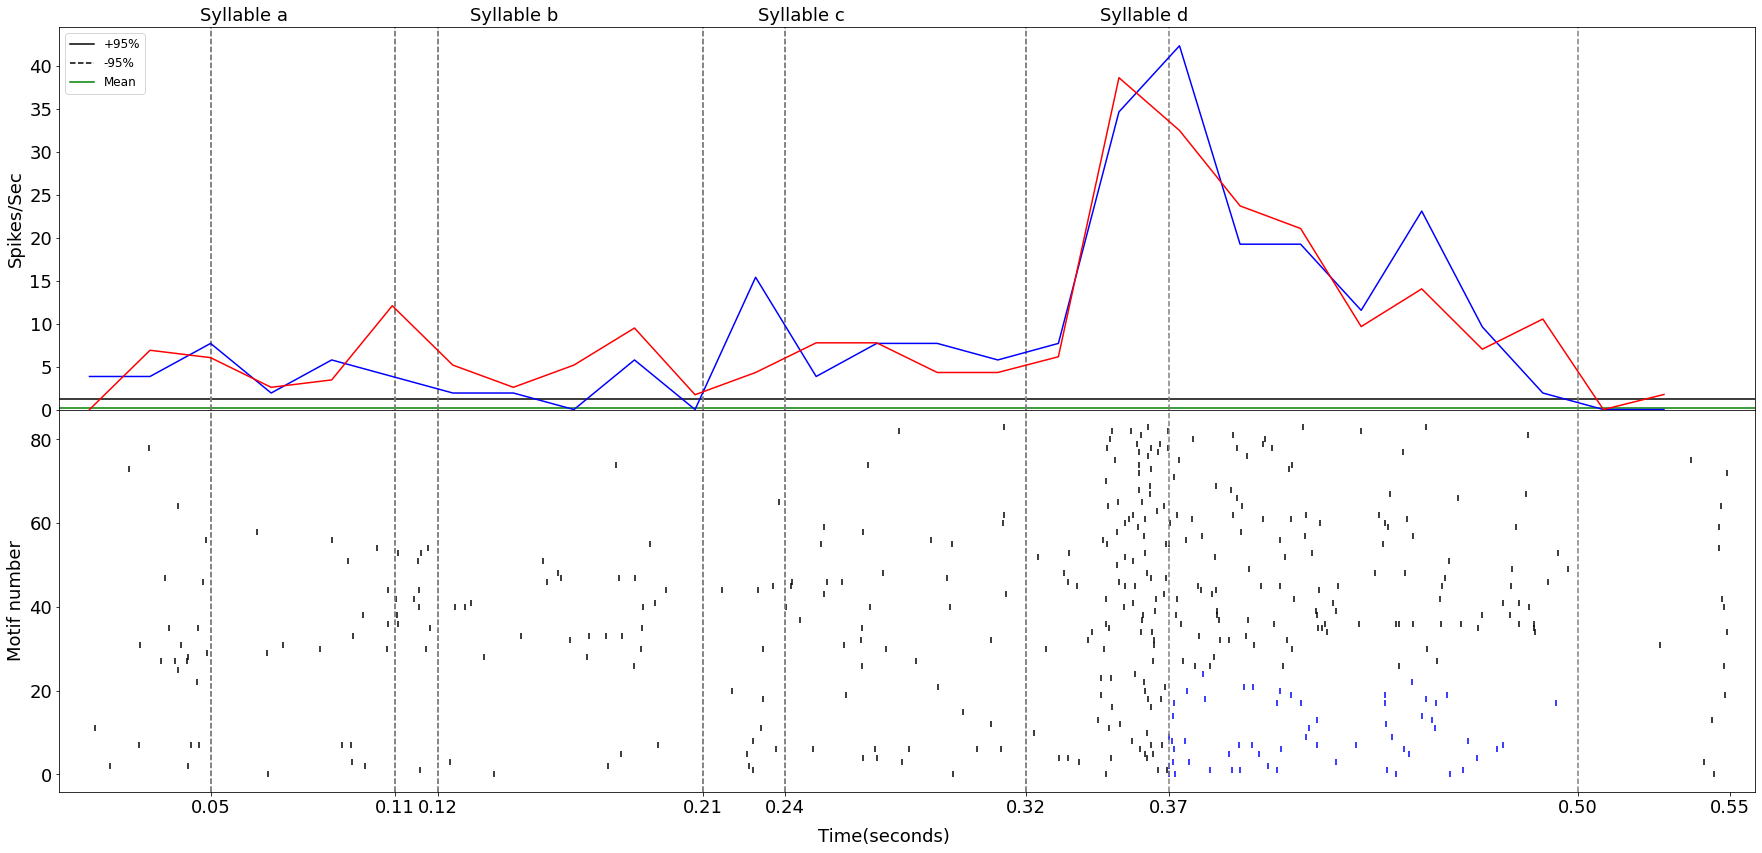

In [27]:
psth_glob_sep_long_noise(spk_ch + '.txt', 'labels.txt', basebeg=base_beg, basend=base_end)

## Final remarks
Now that you've analysed your spiking data, you should be able to define the time window for analysis (e.g. where the spiking activitiy is stable/while the unit wasn't lost). This information can be inputted in the unitswindow.txt in our analysis pipeline. 